### Cell 1: Imports & Setup

In [22]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from planner.dubins_planner import DubinsPlanner
from models.trajectory_tracking_network import TTNetwork

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### 2: Load Training Hyperparameters

In [24]:
# Hyperparameters
MAX_EPISODES = 200
MAX_STEPS = 200
LR = 1e-3
BATCH_SIZE = 5
GAMMA = 0.99

### 3: Intialization 

In [25]:
# Init Enviroment and Dubins Planner
env = UnicycleEnv() 
planner = DubinsPlanner(curvature_max=1.5, step_size=0.2)


# Initilize the Network. 
obs_dim = 3     # Obs dim is 3 (rho, alpha, d_theta)
action_dim = 2  # v, omega

policy = TTNetwork(obs_dim, action_dim).to(device)

optimizer = optim.Adam(policy.parameters(), lr=LR)

gamma = GAMMA

# Memory buffer for the current episode
log_probs = []
rewards = []

# Memory buffer fot the current batch
batch_losses = [] # Store losses from multiple episodes

### 4: Helpers

In [26]:
def get_action(obs):
    """Samples an action and stores its log_probability."""
    obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)

    # Call the network to get a action distribution
    mean, std = policy(obs_t)
    dist = Normal(mean, std)

    # Sample a randome action from this distribution
    # NB: randomcicity ensure exploration
    action = dist.sample()

    # Store log_prob for the update step later
    # Sum over action dimensions (v and omega)
    log_prob = dist.log_prob(action).sum(dim=1)
    log_probs.append(log_prob)

    # Return numpy action for the environment
    # Clip to ensure physical validity [-1, 1]
    return np.clip(action.cpu().detach().numpy()[0], -1.0, 1.0)


def store_reward(reward):
    rewards.append(reward)

### 5: Reinforce Update

In [27]:
def calculate_episode_loss():
    """Calculates loss for a SINGLE trajectory (Inner Sum)"""
    global log_probs, rewards, batch_losses 
    
    R = 0
    returns = []

    # 1. Calculate Cost To Go (Backwards)
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns).to(device)

    # 2. Normalize Returns (Crucial for stability!)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # 3. Compute Loss
    # Action Loss = log_prob * C_t
    policy_loss = []
    for log_prob, G_t in zip(log_probs, returns):
        policy_loss.append(-log_prob * G_t)
    
    # The episode loss is the sum of all action loss
    loss = torch.stack(policy_loss).sum()

    # Store the episode loss in the batch losses buffer
    batch_losses.append(loss)
        
    # Clear step-wise memory for the next episode in the batch
    log_probs = []
    rewards = []
    


"""Monte Carlo Policy Gradient Update"""
def update():
    global batch_losses # Needed to modify the global list
    # Updates policy using the mean of the collected batch (Outer Mean).
    if not batch_losses:        # security check to the batch losses
        return

    # 1. Average over 'm' trajectories
    # loss = (1/m) * sum(episode_losses)
    batch_loss = torch.stack(batch_losses).mean()

    # 2. Backpropagate
    optimizer.zero_grad()       # reset the optimizer
    batch_loss.backward()       # compute the gradient
    optimizer.step()            # update the weight of the network

    # 3. Clear Batch Memory
    batch_losses = []

### 6: Training

In [28]:
reward_history = []

print("Starting Training...")

for episode in range(MAX_EPISODES):
    # 1. Reset & Plan
    obs, info = env.reset()
    start_pose = env.state
    goal_pose = env.goal
    
    # Generate Reference Trajectory
    path = planner.get_path(start_pose, goal_pose)
    if path is None: continue # Skip hard planning cases
        
    path_idx = 0
    ep_reward = 0
    
    # 2. Episode Rollout
    for t in range(MAX_STEPS):
        # A. Determine Target
        target = path[path_idx]
        
        # B. Observation (Relative to Waypoint)
        # Extract only the first 3 element: [rho, alpha, d_theta]
        # Discard the obstacle part, in the first section are not relevant
        tracking_obs = obs[:3]
        
        # C. Action
        action = get_action(tracking_obs)
        
        # D. Step
        # We ignore env reward, we calculate our own
        obs, reward, terminated, truncated, info = env.step(action)
        
        # E. Reward
        store_reward(reward)
        ep_reward += reward
        
        # F. Update Waypoint (Pure Pursuit Logic)
        # If close to current waypoint, target the next one
        if tracking_obs[0] < 0.1 and path_idx < len(path) - 1:
            path_idx += 1
            
        # G. Termination
        dist_to_final = np.linalg.norm(env.state[:2] - goal_pose[:2])
        if dist_to_final < 0.1 and path_idx == len(path) - 1:
            # Success!
            break
        if info['collision']:
            break
            
    # 3. Compute the Episode loss
    calculate_episode_loss()

    # 4. If we have collected 'm' trajectories, perform the update
    if (episode + 1) % BATCH_SIZE == 0:
        update() # This effectively divides by m
        print(f"Update performed at episode {episode}")
    
    reward_history.append(ep_reward)
    
    if (episode + 1) % BATCH_SIZE == 0:
        avg_r = np.mean(reward_history[-20:])
        print(f"Episode {episode} | Avg Reward: {avg_r:.1f} | Path Len: {len(path)}")

print("Training Complete.")

Starting Training...
Update performed at episode 4
Episode 4 | Avg Reward: -968.4 | Path Len: 16
Update performed at episode 9
Episode 9 | Avg Reward: -863.2 | Path Len: 16
Update performed at episode 14
Episode 14 | Avg Reward: -883.3 | Path Len: 25
Update performed at episode 19
Episode 19 | Avg Reward: -973.7 | Path Len: 23
Update performed at episode 24
Episode 24 | Avg Reward: -1056.5 | Path Len: 20
Update performed at episode 29
Episode 29 | Avg Reward: -1154.0 | Path Len: 22
Update performed at episode 34
Episode 34 | Avg Reward: -1215.9 | Path Len: 10
Update performed at episode 39
Episode 39 | Avg Reward: -1232.4 | Path Len: 15
Update performed at episode 44
Episode 44 | Avg Reward: -1236.4 | Path Len: 29
Update performed at episode 49
Episode 49 | Avg Reward: -1325.5 | Path Len: 14
Update performed at episode 54
Episode 54 | Avg Reward: -1400.6 | Path Len: 29
Update performed at episode 59
Episode 59 | Avg Reward: -1406.3 | Path Len: 16
Update performed at episode 64
Episode 

### 7: Visualization
Plot the learning curve to verify convergence.

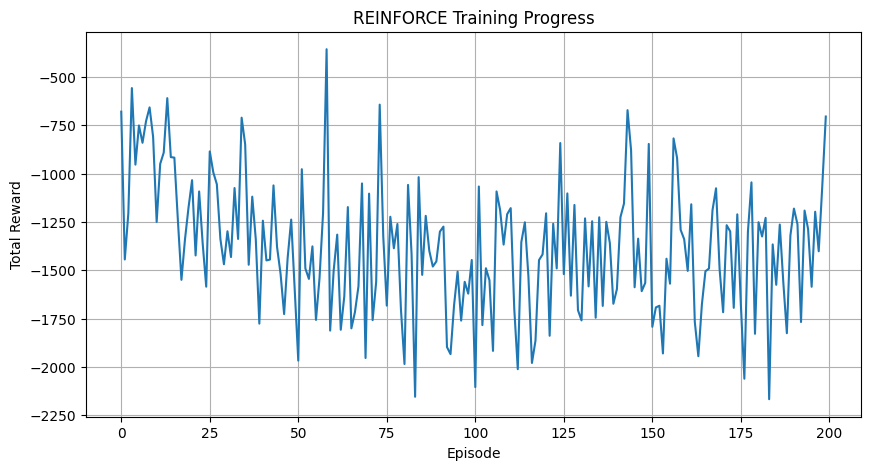

Model saved as tt_network_reinforce.pth


In [29]:
plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.title("REINFORCE Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# Save the trained model
torch.save(policy.state_dict(), "tt_network_reinforce.pth")
print("Model saved as tt_network_reinforce.pth")